### Lab: KFold, Regularization, & Pipelines

Welcome!  This lab is going to introduce us to some very important aspects of data processing and model building.  

Specifically, it's going to go over the following:

 - **KFold Cross Validation:** This is a more thorough way of choosing your validation set to give you a better idea of how your model might perform under various circumstances within your training data.
 - **Regularization:** This is an evergreen technique for dealing with models that are overfit (ie, higher scores on training vs. test data).  Regularized linear models are often much better prepared to handle messy data & outliers when using this technique.
 - **Pipelines:** (Time permitting!) This is an underappreciated aspect of the Scikit-Learn api that allows you to chain together multiple data processing steps, making it much easier to test different models and work seamlessly between your training & test sets.

**Note:** This lab builds off of the one performed in the last class.  As such, it might be easier just to keep working in your previous lab to answer these questions.  It assumes you already have your data processed from the iowa housing lab.  

The questions are listed here just to make the separation of concerns easier.

### Question 1: How Does Your Validation Score Differ Using KFold Cross Validation?

Take a look at the validation score you got from your previous exercise.  

This time, run your model through KFold cross validation using `cross_val_score`.  Is your total validation score appreciably different?  What were your highest and lowest values?

What if you changed your number of folds?  Try using 5, 10, & 25 folds.

In [4]:
# your answer here# these are the steps from the previous lab
import pandas as pd
import numpy as np
train = pd.read_csv('../data/train.csv')
test  = pd.read_csv('../data/test.csv')

# your answer here
y = train['SalePrice']
train.drop('SalePrice', axis=1, inplace=True)
train.drop('Id', axis=1, inplace=True)
test.drop('Id', axis=1, inplace=True)

train_empty = train.loc[:, train.isnull().sum() > 0]
# grab the columns
cols = train_empty.columns.tolist()
# fill with the appropriate value  -- NA, Other, could also work
train[['GarageType', 'GarageFinish']] = train[['GarageType', 'GarageFinish']].fillna('None')
test[['GarageType', 'GarageFinish']]  = test[['GarageType', 'GarageFinish']].fillna('None')

# we'll use this for GarageYrBlt since it's a numeric column
train['GarageYrBlt'].fillna(0, inplace=True)
test['GarageYrBlt'].fillna(0, inplace=True)

# finding the values to use in the training set
ms_mode   = train['MSZoning'].mode()[0]
gcarsmean = train['GarageCars'].mean()

# and applying them to the test set
test['MSZoning'].fillna(ms_mode, inplace=True)
test['GarageCars'].fillna(gcarsmean, inplace=True)

# your code here
# we'll assume the GarageFinish is ordinal.  Ie, FinishedGarage > Unfinished Garage
garage_mapping = {
    'None': 0, # no garage
    'Unf' : 1, # unfinished garage
    'RFn' : 2, # partially finished garage
    'Fin' : 3  # finished garage
}

train['GarageFinish'] = train['GarageFinish'].map(garage_mapping)
test['GarageFinish']  = test['GarageFinish'].map(garage_mapping)

# MSSubClass is really a category, moreso than a true number
# so we'll add it to the list of items to be encoded
train['MSSubClass'] = train['MSSubClass'].astype(str)
test['MSSubClass']  = test['MSSubClass'].astype(str)

# concatenate and encode
master = pd.concat([train, test])
master = pd.get_dummies(master)

# drop MSSubClass150
master.drop('MSSubClass_150', axis=1, inplace=True)

# and split back apart
train  = master.iloc[:1460].copy()
test   = master.iloc[1460:].copy()

# save these values, to use on both your training and test set
train_means = train.mean()
train_stds  = train.std()

# standardize the training set
train -= train_means
train /= train_stds

# and do the same for the test set
test -= train_means
test /= train_stds

In [6]:
y.head()

0    208500
1    181500
2    223500
3    140000
4    250000
Name: SalePrice, dtype: int64

In [5]:
train.head()

,LotArea,OverallQual,OverallCond,YearBuilt,GrLivArea,1stFlrSF,2ndFlrSF,GrLivArea.1,FullBath,HalfBath,...,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,GarageType_2Types,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageType_None
0,-0.207071,0.651256,-0.517023,1.050634,0.370207,-0.793162,1.161454,0.370207,0.789470,1.227165,...,-0.131946,-0.163415,-0.087099,-0.064216,0.823223,-0.114788,-0.253172,-0.07873,-0.600353,-0.242277
1,-0.091855,-0.071812,2.178881,0.156680,-0.482347,0.257052,-0.794891,-0.482347,0.789470,-0.761360,...,-0.131946,-0.163415,11.473319,-0.064216,0.823223,-0.114788,-0.253172,-0.07873,-0.600353,-0.242277
2,0.073455,0.651256,-0.517023,0.984415,0.514836,-0.627611,1.188943,0.514836,0.789470,1.227165,...,-0.131946,-0.163415,-0.087099,-0.064216,0.823223,-0.114788,-0.253172,-0.07873,-0.600353,-0.242277
3,-0.096864,0.651256,-0.517023,-1.862993,0.383528,-0.521555,0.936955,0.383528,-1.025689,-0.761360,...,-0.131946,-0.163415,-0.087099,-0.064216,-1.213905,-0.114788,-0.253172,-0.07873,1.664545,-0.242277
4,0.375020,1.374324,-0.517023,0.951306,1.298881,-0.045596,1.617323,1.298881,0.789470,1.227165,...,-0.131946,-0.163415,-0.087099,-0.064216,0.823223,-0.114788,-0.253172,-0.07873,-0.600353,-0.242277


In [12]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
cvs = [5, 10, 25]
cv5 = cross_val_score(lr, X=train, y=y, cv=cvs[0])
cv10 = cross_val_score(lr, X=train, y=y, cv=cvs[1])
cv25 = cross_val_score(lr, X=train, y=y, cv=cvs[2])
cv_scores = [cross_val_score(lr, X=train, y=y, cv=i) for i in cvs]

In [11]:
print('5 fold CV:', '-'*25, cv5, '\n', sep='\n')
print(cv5.min(), cv5.max(), cv5.std())
print('10 fold CV:', '-'*25, cv10, '\n', sep='\n')
print(cv10.min(), cv10.max(), cv10.std())
print('25 fold CV:', '-'*25, cv25, '\n', sep='\n')
print(cv25.min(), cv25.max(), cv25.std())

5 fold CV:
-------------------------
[0.8672403  0.82996498 0.82988874 0.82259029 0.73647959]


0.7364795903283214 0.8672403027527855 0.04329622420683497
10 fold CV:
-------------------------
[0.8698292  0.86872385 0.90039109 0.77416761 0.82789523 0.83483228
 0.81937276 0.81978263 0.6624736  0.85162283]


0.662473603885437 0.9003910944086757 0.06279570903763354
25 fold CV:
-------------------------
[0.89169958 0.82401953 0.8775956  0.86142958 0.90050608 0.90731896
 0.89265571 0.81764167 0.74547212 0.79276342 0.87300321 0.80286892
 0.81504411 0.82404576 0.91093031 0.7844823  0.87247875 0.84910225
 0.76934216 0.81469008 0.74870837 0.86497941 0.11783357 0.87003587
 0.87715818]


0.11783356871476669 0.9109303091746784 0.14955288003945627


In [13]:
cvdict = {}
for cv, fold in zip(cvs, cv_scores):
    cvdict[cv] = fold.mean()

In [14]:
cvdict

{5: 0.8172327811582084, 10: 0.8229091090102086, 25: 0.8122322198428682}

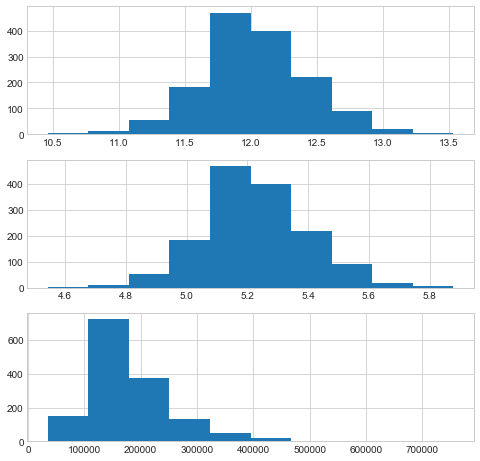

In [28]:
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
fig, ax = plt.subplots(3, figsize=(8,8))
np.log(y).hist(ax=ax[0])
np.log10(y).hist(ax=ax[1])
y.hist(ax=ax[2])


In [29]:
cv_scores_log = [cross_val_score(lr, X=train, y=np.log(y), cv=i) for i in cvs]

In [33]:
cv_log_dict = {}
for folds, scores in zip(cvs, cv_scores_log):
    cv_log_dict[folds] = {'mean': scores.mean(),
                          'median': np.median(scores),
                          'std': scores.std()}
    
print(cv_log_dict)

{5: {'mean': 0.8650290415468866, 'median': 0.8697462682984962, 'std': 0.028310257006966204}, 10: {'mean': 0.8628872554110364, 'median': 0.8750473805855438, 'std': 0.051933884093512926}, 25: {'mean': 0.8618427057374928, 'median': 0.8825837190524161, 'std': 0.08323319826071719}}


### Question 2: Updating Your Model With Ridge & Lasso Regression

Instead of using Linear Regression, import `Ridge` or `Lasso`, and use cross validation to find the ideal value of alpha.  

Some basic tips:

For values of alpha try this:  `alphas = np.logspace(-4, 4, 9)`
Then write a `for-loop` that generically goes like this:

`for value in alphas:
    1). set value of alpha to current value using set_params() method
    2). pass in instance of Ridge or Lasso into cross_val_score
    3). using a tuple, append the average of all results from step 2 into a list, along with the value of alpha`
    
When you're finished, you should have a list that has 9 tuples inside it, each one with the average cross validation score as well as the value of alpha associated with it.

In [44]:
from sklearn.linear_model import Lasso, Ridge

lasso = Lasso()
ridge = Ridge()

In [47]:
alphas = np.logspace(-4, 4, num=9)
lasso_scores = []
ridge_scores = []

for alpha in alphas:
    lasso.set_params(alpha=alpha)
    lasso_scores.append((cross_val_score(lasso, train, np.log(y), cv=10).mean(), alpha))
    ridge.set_params(alpha=alpha)
    ridge_scores.append((cross_val_score(ridge, X=train, y=np.log(y), cv=10).mean(), alpha))

C:\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.02621377476420861, tolerance: 0.02100187174002019
  positive)


In [50]:
print(*lasso_scores, sep='\n')
print(max(lasso_scores)[1])

[(0.8634425048822774, 0.0001), (0.864191084904902, 0.001), (0.8544354808965491, 0.01), (0.6909458322110515, 0.1), (-0.007368842975429635, 1.0), (-0.007368842975429635, 10.0), (-0.007368842975429635, 100.0), (-0.007368842975429635, 1000.0), (-0.007368842975429635, 10000.0)]
0.001


In [52]:
print(*ridge_scores, sep='\n')
print(max(ridge_scores)[1])

(0.8628836012707453, 0.0001)
(0.8628843968787981, 0.001)
(0.862892212874151, 0.01)
(0.8629586815873479, 0.1)
(0.8632282377170221, 1.0)
(0.8637818510552357, 10.0)
(0.8652092706925322, 100.0)
(0.8442515828165693, 1000.0)
(0.584125235255362, 10000.0)
100.0


**Bonus:** In Scikit-Learn cross validation is sometimes built into algorithms automatically.  Luckily this is the case with `Ridge` and `Lasso`.  If you're inclined to take a look at the `RidgeCV` and `LassoCV` methods, you can basically combine what we just did into one step.

**Note:** These aren't always available, and they don't always work in the same way, so remember that they won't always be an option.

**RidgeCV:** https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RidgeCV.html
**LassoCV:** https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LassoCV.html

### Step 3: Building A Pipeline

Let's try building some pipelines to test out different versions of our models more easily.  

For this one, we are going to start fresh a little bit to get the hang of using our pipelines, and to go through the entire process.

So......

**a)** Reload the training and test sets

 - create a new variable for `y`, and set it equal to the log of `SalePrice`
 - create a variable for the `id` column in the test set -- this will be reused later

In [100]:
train = pd.read_csv('../data/train.csv')
test = pd.read_csv('../data/test.csv')

In [101]:
X = train.drop('SalePrice', axis=1)
y = train['SalePrice']
y = np.log(y)
X.drop('Id', axis=1, inplace=True)
test.drop('Id', axis=1, inplace=True)

**b)** Fill in the missing data on training & test

**Note:** If you feel like you have a good handle on this, you can just copy and paste from your previous solutions or the lab manual.  

If you have the time and think you need extra practice, feel free to try and re-create the results on your own.....just be mindful of time.

In [102]:
X_empty = train.loc[:, train.isnull().sum() > 0]
col = X_empty.columns.to_list()

X[['GarageType', 'GarageFinish']] = X[['GarageType', 'GarageFinish']].fillna('None')
test[['GarageType', 'GarageFinish']] = test[['GarageType', 'GarageFinish']].fillna('None')

X['GarageYrBlt'].fillna(0, inplace=True)
test['GarageYrBlt'].fillna(0, inplace=True)

# finding the values to use in the training set
ms_mode   = X['MSZoning'].mode()[0]
gcarsmean = X['GarageCars'].mean()

# and applying them to the test set
test['MSZoning'].fillna(ms_mode, inplace=True)
test['GarageCars'].fillna(gcarsmean, inplace=True)

# your code here
# we'll assume the GarageFinish is ordinal.  Ie, FinishedGarage > Unfinished Garage
# garage_mapping = {
#     'None': 0, # no garage
#     'Unf' : 1, # unfinished garage
#     'RFn' : 2, # partially finished garage
#     'Fin' : 3  # finished garage
# }

# X['GarageFinish'] = X['GarageFinish'].map(garage_mapping)
# test['GarageFinish']  = test['GarageFinish'].map(garage_mapping)



**c)** Reclassify the `MSSubClass` column as a string

In [103]:
# MSSubClass is really a category, moreso than a true number
# so we'll add it to the list of items to be encoded
X['MSSubClass'] = X['MSSubClass'].astype(str)
test['MSSubClass']  = test['MSSubClass'].astype(str)

**d)** Create Your Pipeline!


a). Initialize instances for each of the following items:

 - An ordinal encoder for the `GarageFinish` column (be careful about the mapping dictionary here)
 - A categorical encoder for your nominal columns
 - The standard scaler
 - Lasso or Ridge regression, with the cross validated value of alpha from the previous exercise

In [104]:
mapping = {
    'col': 'GarageFinish',
    'mapping': {
        'None': 0, # no garage
        'Unf' : 1, # unfinished garage
        'RFn' : 2, # partially finished garage
        'Fin' : 3  # finished garage
    }
}

In [109]:
import category_encoders as ce
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge

ridge = Ridge()
sc = StandardScaler()
ore = ce.OrdinalEncoder(cols=['GarageFinish'], mapping=[mapping])
ohe = ce.OneHotEncoder()

In [110]:
pipe = make_pipeline(ore, ohe, sc, ridge)

In [111]:
# fit and transform the oridinal columns with the ordincal encoder
# ore.fit_transform(X)

In [112]:
pipe.fit(X, y=y)

Pipeline(memory=None,
         steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['GarageFinish'], drop_invariant=False,
                                handle_missing='value', handle_unknown='value',
                                mapping=[{'col': 'GarageFinish',
                                          'mapping': {'Fin': 3, 'None': 0,
                                                      'RFn': 2, 'Unf': 1}}],
                                return_df=True, verbose=0)),
                ('onehotencoder',
                 OneHotEncoder(cols=['MSSubClass', 'MSZoning', 'Neighborhood',
                                     'GarageType'],
                               drop_invariant=False, handle_missing='value',
                               handle_unknown='value', return_df=True,
                               use_cat_names=False, verbose=0)),
                ('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('r

In [115]:
cross_val_score(pipe, X=X, y=y, cv=10)

array([0.87437439, 0.91234571, 0.91290423, 0.82657394, 0.86676275,
       0.86542806, 0.8769858 , 0.89144589, 0.72653906, 0.87891162])

In [116]:
alphas = np.logspace(-3, 3, 7)
cv_scores = []

for alpha in alphas:
    pipe.steps[-1][1].set_params(alpha=alpha)
    scores = cross_val_score(estimator=pipe, X=X, y=y, cv=10)
    cv_scores.append((np.mean(scores), alpha))

In [117]:
cv_scores

[(0.8628844021672876, 0.001),
 (0.8628922631891338, 0.01),
 (0.8629589887467667, 0.1),
 (0.8632271451896907, 1.0),
 (0.8637652063955132, 10.0),
 (0.8651023941990363, 100.0),
 (0.8445309718475507, 1000.0)]

In [118]:
max(cv_scores)

(0.8651023941990363, 100.0)

**e)** Fit the pipeline on your training set, and predict the values on your test set

 - to get the "real" values of your prediction you would use the function `np.exp()`
 
ie, if `pipe.predict(test)` gives you the predicted log values of your test set, then `np.exp(pipe.predict(test))` would give you the actual expected housing prices.

In [120]:
pipe.steps[-1][1].set_params(alpha=max(cv_scores)[1])

np.exp(pipe.predict(test))

array([117757.19893444, 153765.15486921, 170628.65553705, ...,
       150764.80850924, 117678.20922137, 226557.41950875])